## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers, backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
from typing import Optional, Union

Number = Union[
    float,
    int,
    np.float16,
    np.float32,
    np.float64,
    np.int8,
    np.int16,
    np.int32,
    np.int64,
    np.uint8,
    np.uint16,
    np.uint32,
    np.uint64,
]

class WeightedKappaLoss(tf.keras.losses.Loss):
    """Implements the Weighted Kappa loss function.
    Weighted Kappa loss was introduced in the
    [Weighted kappa loss function for multi-class classification
    of ordinal data in deep learning]
    (https://www.sciencedirect.com/science/article/abs/pii/S0167865517301666).
    Weighted Kappa is widely used in Ordinal Classification Problems.
    The loss value lies in [-inf, log 2], where log 2
     means the random prediction.
    Usage:
    ```python
    kappa_loss = WeightedKappaLoss(num_classes=4)
    y_true = tf.constant([[0, 0, 1, 0], [0, 1, 0, 0],
                          [1, 0, 0, 0], [0, 0, 0, 1]])
    y_pred = tf.constant([[0.1, 0.2, 0.6, 0.1], [0.1, 0.5, 0.3, 0.1],
                          [0.8, 0.05, 0.05, 0.1], [0.01, 0.09, 0.1, 0.8]])
    loss = kappa_loss(y_true, y_pred)
    print('Loss: ', loss.numpy())  # Loss: -1.1611923
    ```
    Usage with `tf.keras` API:
    ```python
    # outputs should be softmax results
    # if you want to weight the samples, just multiply the outputs
    # by the sample weight.
    model = tf.keras.Model(inputs, outputs)
    model.compile('sgd', loss=tfa.losses.WeightedKappa(num_classes=4))
    ```
    """

    def __init__(
        self,
        num_classes: int,
        weightage: Optional[str] = "quadratic",
        name: Optional[str] = "cohen_kappa_loss",
        epsilon: Optional[Number] = 1e-6,
        dtype: Optional[tf.DType] = tf.float32,
        reduction: str = tf.keras.losses.Reduction.NONE,
    ):
        """Creates a `WeightedKappa` instance.
        Args:
          num_classes: Number of unique classes in your dataset.
          weightage: (Optional) Weighting to be considered for calculating
            kappa statistics. A valid value is one of
            ['linear', 'quadratic']. Defaults to `quadratic` since it's
            mostly used.
          name: (Optional) String name of the metric instance.
          epsilon: (Optional) increment to avoid log zero,
            so the loss will be log(1 - k + epsilon), where k belongs to
            [-1, 1], usually you can use the default value which is 1e-6.
          dtype: (Optional) Data type of the metric result.
            Defaults to `tf.float32`.
        Raises:
          ValueError: If the value passed for `weightage` is invalid
            i.e. not any one of ['linear', 'quadratic']
        """

        super().__init__(name=name, reduction=reduction)

        if weightage not in ("linear", "quadratic"):
            raise ValueError("Unknown kappa weighting type.")

        self.weightage = weightage
        self.num_classes = num_classes
        self.epsilon = epsilon
        self.dtype = dtype
        label_vec = tf.range(num_classes, dtype=dtype)
        self.row_label_vec = tf.reshape(label_vec, [1, num_classes])
        self.col_label_vec = tf.reshape(label_vec, [num_classes, 1])
        col_mat = tf.tile(self.col_label_vec, [1, num_classes])
        row_mat = tf.tile(self.row_label_vec, [num_classes, 1])
        if weightage == "linear":
            self.weight_mat = tf.abs(col_mat - row_mat)
        else:
            self.weight_mat = (col_mat - row_mat) ** 2

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, dtype=self.dtype)
        batch_size = tf.shape(y_true)[0]
        cat_labels = tf.matmul(y_true, self.col_label_vec)
        cat_label_mat = tf.tile(cat_labels, [1, self.num_classes])
        row_label_mat = tf.tile(self.row_label_vec, [batch_size, 1])
        if self.weightage == "linear":
            weight = tf.abs(cat_label_mat - row_label_mat)
        else:
            weight = (cat_label_mat - row_label_mat) ** 2
        numerator = tf.reduce_sum(weight * y_pred)
        label_dist = tf.reduce_sum(y_true, axis=0, keepdims=True)
        pred_dist = tf.reduce_sum(y_pred, axis=0, keepdims=True)
        w_pred_dist = tf.matmul(self.weight_mat, pred_dist, transpose_b=True)
        denominator = tf.reduce_sum(tf.matmul(label_dist, w_pred_dist))
        denominator /= tf.cast(batch_size, dtype=self.dtype)
        loss = tf.math.divide_no_nan(numerator, denominator)
        return tf.math.log(loss + self.epsilon)

    def get_config(self):
        config = {
            "num_classes": self.num_classes,
            "weightage": self.weightage,
            "epsilon": self.epsilon,
            "dtype": self.dtype,
        }
        base_config = super().get_config()
        return {**base_config, **config}

# Load data

In [3]:
database_base_path = '/kaggle/input/tweet-dataset-split-roberta-base-96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_1.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_2.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_3.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_4.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_5.tar.gz

,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_1/x_valid.npy
fold_2/
fold_2/y_train.npy
fold_2/x_train.npy
fold_2/y_valid.npy
fold_2/x_valid.npy
fold_3/
fold_3/y_train.npy
fold_3/x_train.npy
fold_3/y_valid.npy
fold_3/x_valid.npy


# Model parameters

In [4]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 6,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 1,
  "question_size": 4,
  "N_FOLDS": 3,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [5]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1e-06


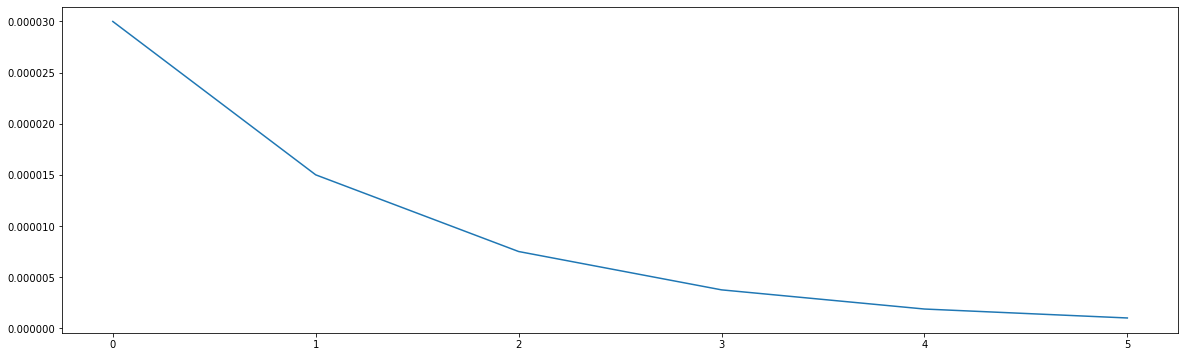

In [6]:
LR_MIN = 1e-6
LR_MAX = config['LEARNING_RATE']
LR_EXP_DECAY = .5

@tf.function
def lrfn(epoch):
    lr = LR_MAX * LR_EXP_DECAY**epoch
    if lr < LR_MIN:
        lr = LR_MIN
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_start = layers.Dropout(.1)(last_hidden_state) 
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)
    y_start_sig = layers.Activation('sigmoid', name='y_start_sig')(x_start)

    x_end = layers.Dropout(.1)(last_hidden_state) 
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)
    y_end_sig = layers.Activation('sigmoid', name='y_end_sig')(x_end)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end, y_start_sig, y_end_sig])
    
    optimizer = optimizers.Adam(lr=config['LEARNING_RATE'])
    model.compile(optimizer, loss={'y_start': losses.CategoricalCrossentropy(),
                                   'y_end': losses.CategoricalCrossentropy(),
                                   'y_start_sig': losses.BinaryCrossentropy(),
                                   'y_end_sig': losses.BinaryCrossentropy()},
                             metrics={'y_start': metrics.CategoricalAccuracy(),
                                      'y_end': metrics.CategoricalAccuracy()})
    
    return model

# Train

In [8]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    lr_schedule = LearningRateScheduler(lrfn)

    history = model.fit(list(x_train), list(y_train) + list(y_train),
                        validation_data=(list(x_valid), list(y_valid) + list(y_valid)),
                        batch_size=config['BATCH_SIZE'], 
                        callbacks=[checkpoint, es, lr_schedule],
                        epochs=config['EPOCHS'], 
                        verbose=2).history
    history_list.append(history)
    
    # Make predictions
    train_preds = model.predict(list(x_train))
    valid_preds = model.predict(list(x_valid))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train on 21984 samples, validate on 5496 samples
Epoch 1/6
21984/21984 - 287s - loss: 2.2198 - y_start_loss: 1.0913 - y_end_loss: 1.0732 - y_start_sig_loss: 0.0275 - y_end_sig_loss: 0.0278 - y_start_categorical_accuracy: 0.6439 - y_end_categorical_accuracy: 0.6548 - val_loss: 1.6649 - val_y_start_loss: 0.8476 - val_y_end_loss: 0.7829 - val_y_start_sig_loss: 0.0164 - val_y_end_sig_loss: 0.0171 - val_y_start_categorical_accuracy: 0.7023 - val_y_end_categorical_accuracy: 0.7207
Epoch 2/6
21984/21984 - 272s - loss: 1.6102 - y_start_loss: 0.8195 - y_end_loss: 0.7596 - y_start_sig_loss: 0.0158 - y_end_sig_loss: 0.0153 - y_start_categorical_accuracy: 0.7063 - y_end_categorical_accuracy: 0.7303 - val_loss: 1.5768 - val_y_start_loss: 0.7980 - val_y_end_loss: 0.7489 - val_y_start_sig_loss: 0.0157 - val_y_end_sig_loss: 0.0136 - val_y_start_categorical_accuracy: 0.7136 - val_y_end_categorical_accuracy: 0.7273
Epoch 3/6
21984/21984 - 272s - loss: 1.4552 - y_start_loss: 0.7456 - y_end_loss:

# Model loss graph

Fold: 1


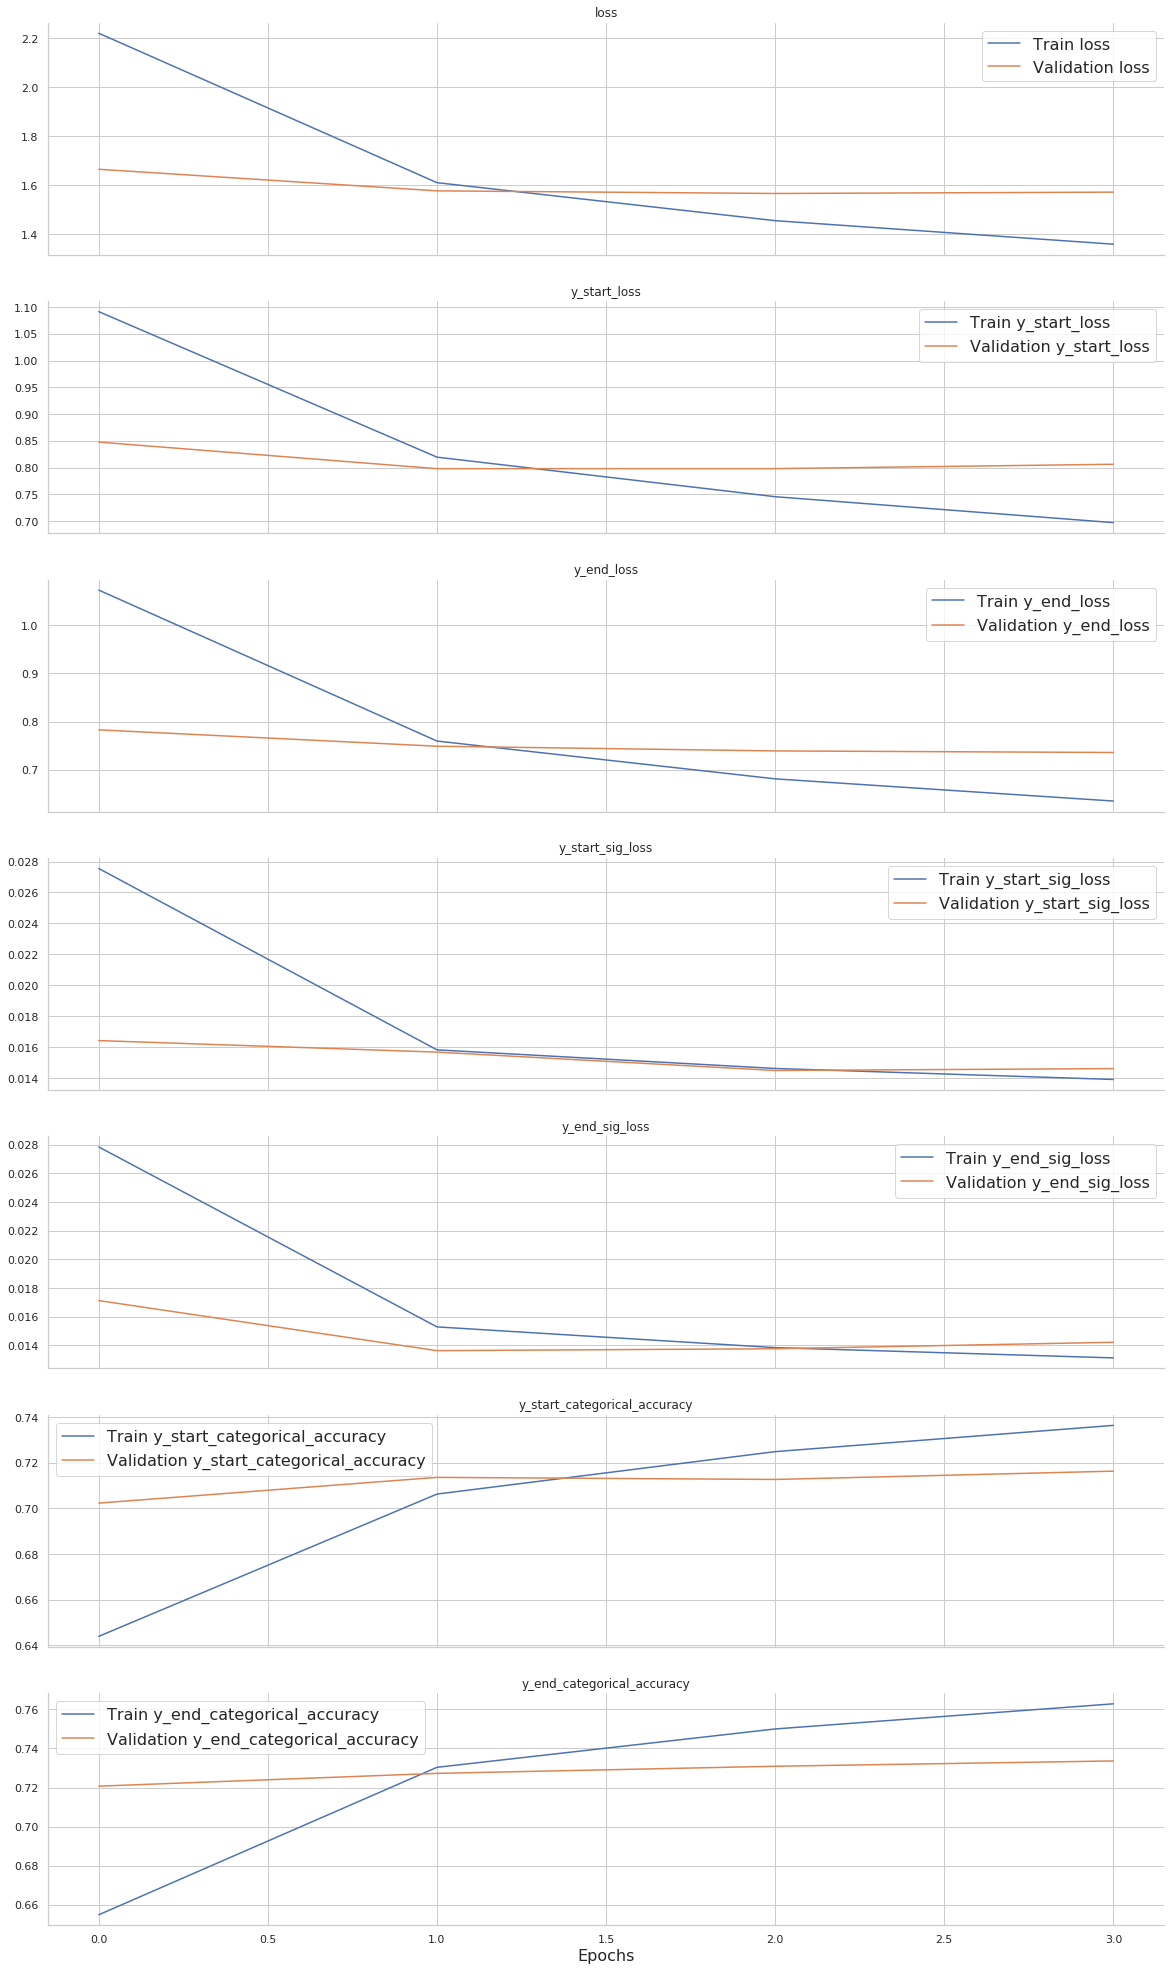

Fold: 2


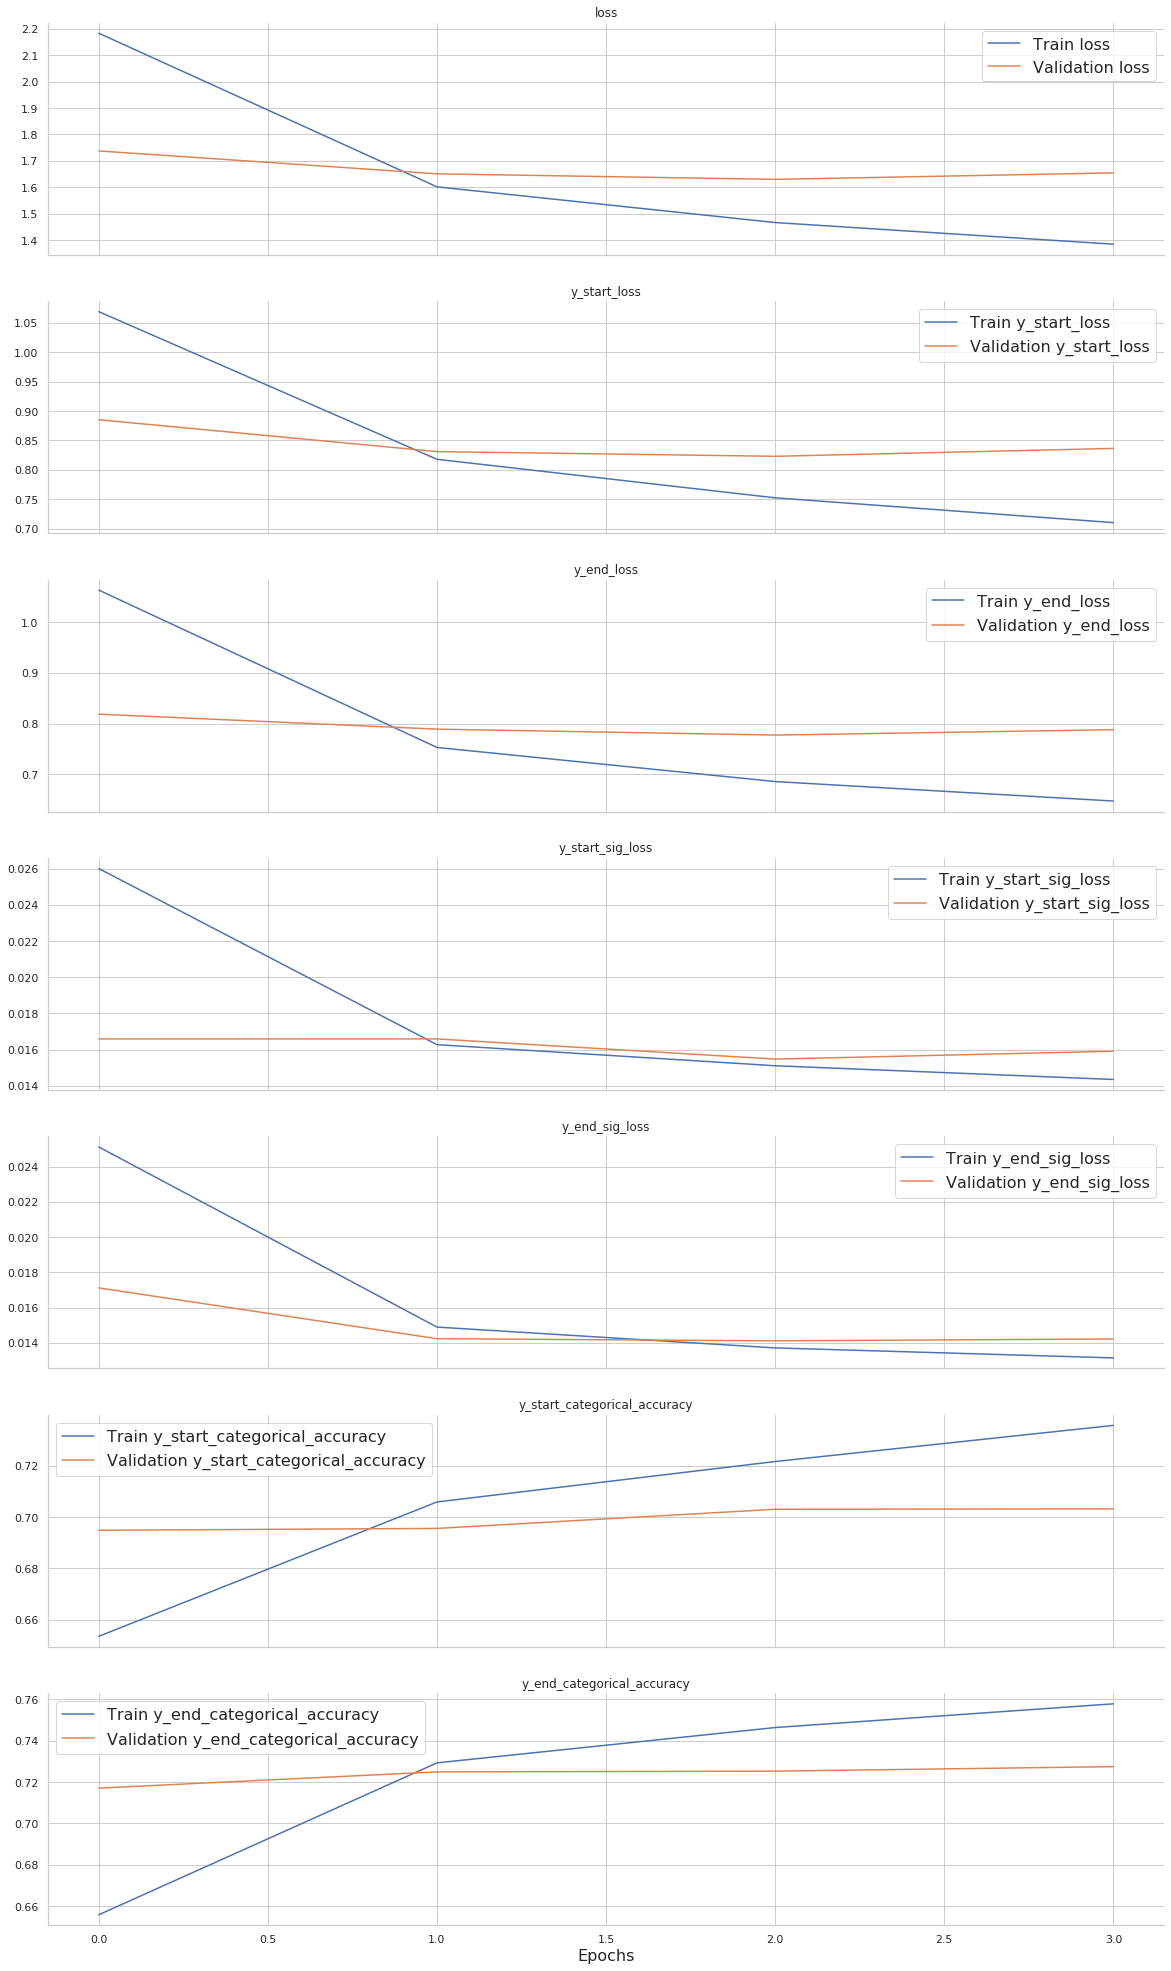

Fold: 3


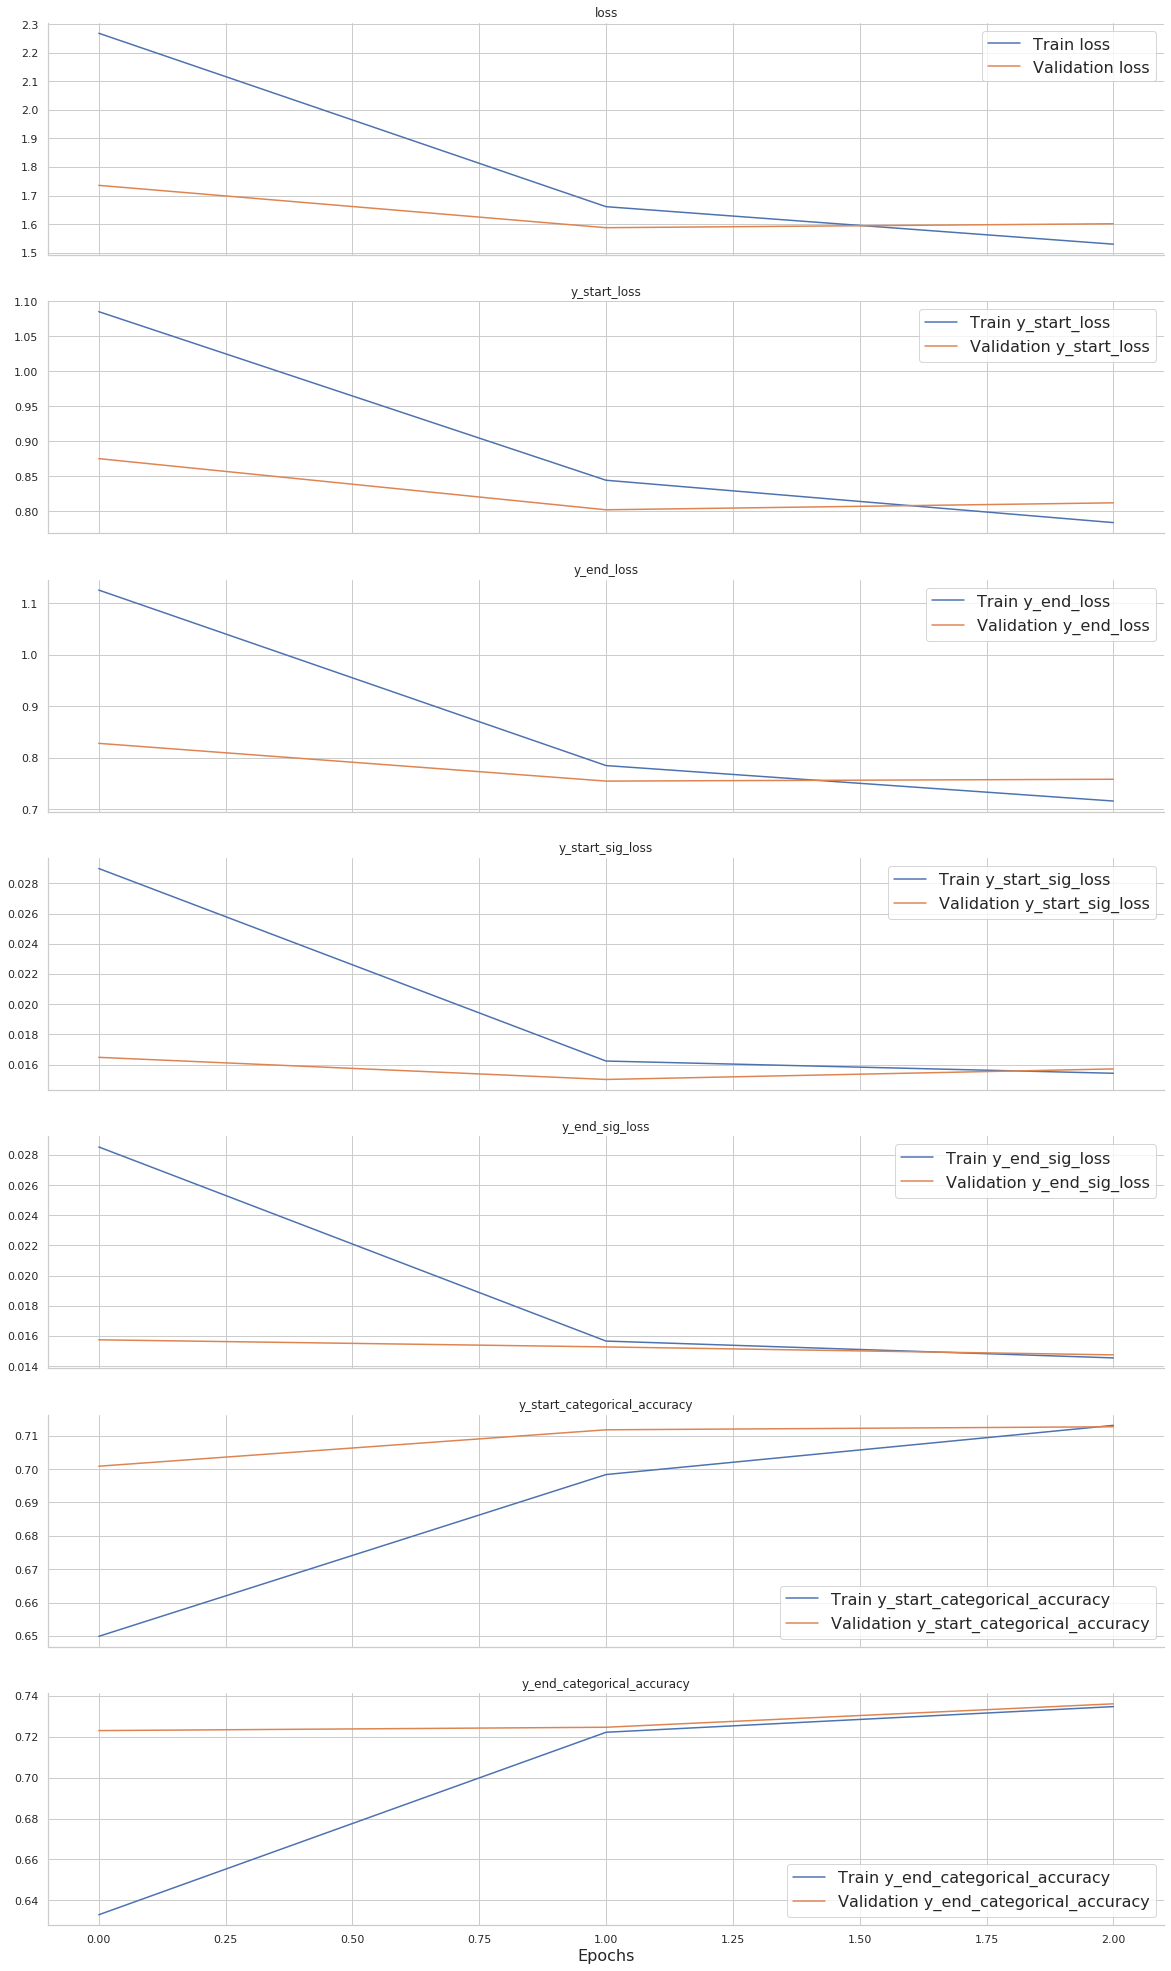

In [9]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [10]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric/Jaccard,,,,,,,,,
Overall,0.737505,0.703423,0.034082,0.748968,0.706875,0.743675,0.697911,0.719872,0.705483
Sentiment neutral,0.974173,0.973844,0.000329,0.974177,0.974037,0.974586,0.972531,0.973756,0.974963
Sentiment negative,0.584118,0.520948,0.063169,0.603960,0.521579,0.593445,0.513096,0.554948,0.528169
Sentiment positive,0.570014,0.518495,0.051519,0.588741,0.528641,0.580799,0.509575,0.540503,0.517269
0 <= text wordCnt < 3,0.863059,0.849411,0.013648,0.867424,0.820896,0.863664,0.866446,0.858089,0.860892
3 <= text wordCnt < 10,0.790717,0.766666,0.024051,0.800668,0.760295,0.794124,0.765395,0.777360,0.774309
10 <= text wordCnt < 30,0.704404,0.665581,0.038823,0.717692,0.673219,0.711868,0.658191,0.683654,0.665334
30 <= text wordCnt < 100,0.692009,0.590224,0.101784,0.660750,0.684751,0.734157,0.512113,0.681118,0.573809
0 <= selected text wordCnt < 3,0.664372,0.600676,0.063697,0.684119,0.605982,0.673054,0.597729,0.635944,0.598316


# Visualize predictions

In [11]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,sooo sad,1.000000,sooo sad,1.000000,sad,0.500000
2,my boss is bullying me...,bullying me,negative,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,"sons of ****,",1.000000,"****,",0.333333,"****,",0.333333
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000
6,2am feedings for the baby are fun when he is a...,fun,positive,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,wow...,0.200000,wow... u just became cooler.,1.000000,wow...,0.200000
